In [3]:
import os
VERSION = 9
if VERSION is not None:
    os.environ["CC"] = f"/usr/bin/gcc-{VERSION}"
    os.environ["CXX"] = f"/usr/bin/g++-{VERSION}"
from pathlib import Path
import sys
sys.path.append(str(Path(os.path.abspath('')).parent))
print(str(Path(os.path.abspath('')).parent))
import math
import torch
import matplotlib.pyplot as plt
import mediapy
from icecream import ic
from data import loader
import random
import time
from tqdm import tqdm
import numpy as np
from utils import cam_util
from utils.train_util import *
from models.vertex_color import Model, TetOptimizer
from fused_ssim import fused_ssim
from pathlib import Path, PosixPath
from utils.args import Args
import pickle
import json
from utils import safe_math
from delaunay_rasterization.internal.render_err import render_err
import imageio

device = torch.device("cuda")
args = lambda x: x
args.dataset_path = Path("/optane/nerf_datasets/360/bicycle")
args.output_path = Path("output/test/")
args.image_folder = "images_4"
args.tile_size = 16
args.lambda_ssim = 0.0

train_cameras, test_cameras, scene_info = loader.load_dataset(
    args.dataset_path, args.image_folder, data_device="cuda", eval=True)

cmap = plt.get_cmap("jet")
path = (str(Path(os.path.abspath('')).parent / "ckpt.ply"))
model = Model.load_ply(path, device)
camera = train_cameras[0]
target = camera.original_image.cuda()

/home/dronelab/delaunay_rasterization
Reading camera 194/194
Loaded Train Cameras: 169
Loaded Test Cameras: 25


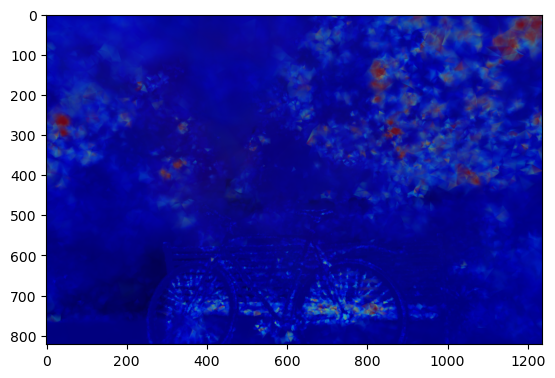

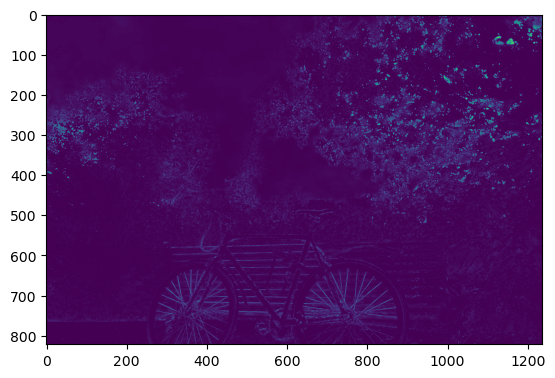

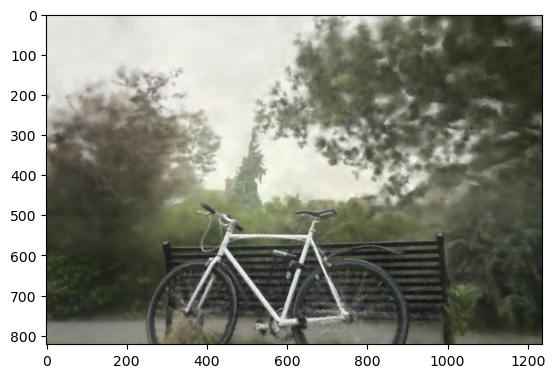

In [4]:
def disp(im):
    im = (im.detach().cpu().numpy() * 255).clip(min=0, max=255).astype(np.uint8)
    plt.imshow(im)
    plt.show()

with torch.no_grad():
    tet_rgbs_grad, render_pkg2 = render_err(target, camera, model, tile_size=args.tile_size, lambda_ssim=args.lambda_ssim)
    # tet_rgbs_grad = update_rgbs(tet_rgbs_grad, tet_grad, render_pkg['tet_area'])

with torch.no_grad():
    tensor_min, tensor_max = tet_rgbs_grad.min(), tet_rgbs_grad.max()
    normalized_tensor = (tet_rgbs_grad - tensor_min) / (tensor_max - tensor_min)

    # Convert to RGB (NxMx3) using the colormap
    tet_grad_color = torch.as_tensor(cmap(normalized_tensor.cpu().numpy())).float().cuda()
    tet_grad_color[:, 3] = model.get_cell_values(camera)[:, 3]
    render_pkg = render(camera, model, cell_values=tet_grad_color, tile_size=args.tile_size)

    image = render_pkg['render']
    image = image.permute(1, 2, 0)
    disp(image)
    disp(render_pkg2['pixel_err'])
    disp(render_pkg2['render_img'].permute(1, 2, 0))